In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate as interp
import scipy.integrate as integ
import pandas as pd

%matplotlib notebook

MOTOR_ENG_FILE = input("enter the filename of your ENG file:")

enter the filename of your ENG file:AeroTech_J450.eng


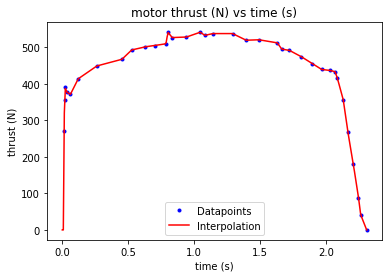

In [4]:
# First we're gonna define our figure
plt.figure()
plt.title("motor thrust (N) vs time (s)")
plt.xlabel("time (s)")
plt.ylabel("thrust (N)")

# Then we load motor data from a text file
motor = np.loadtxt(MOTOR_ENG_FILE, skiprows=2)

# By interploating it we are basically saying that if we want the thrust at a time we don't
# have data for, draw a line between the point before and the point after using in this example
# y=mx+b and evaluate that function at the time we want
motorinterp = sp.interpolate.interp1d(motor[::,0], motor[::,1])

# this is a model of our motor thrust as a function od time
def motor_model(t):
    # If we ask for a time before or after the range we assume thrust is zero
    if t > np.max(motor[::,0]) or t < np.min(motor[::,0]):
        return 0
    # Otherwise we use the interpolate function
    return motorinterp(t)

# Plot motor thrust interpolation and actual datapoints
plt.plot(motor[::,0], motor[::,1], "b.", label="Datapoints")
plt.plot(np.linspace(0, np.max(motor[::,0]), 300), [motor_model(i) for i in np.linspace(0, np.max(motor[::,0]), 300)], "r-", label="Interpolation")
plt.legend()

In [ ]:
# We're going to assume the mass of the motor decreases linearly from the beginning to the end of the burn
# Here we are basically doing interpolation ourselves (this is all Kg)

def j450_mass(t):
    MASS_INIT = 1223 / 1000
    MASS_FINAL = (1223 - 510) / 1000
    BURN_TIME = 2.3
    if t < 0:
        return MASS_INIT
    if t > BURN_TIME:
        return MASS_FINAL
    # y = mx + b
    return ((MASS_FINAL - MASS_INIT)/BURN_TIME)*t + MASS_INIT

# Lets plot it just to make sure it looks like we want
plt.figure()
plt.xlabel("time")
plt.ylabel("Motor Mass (kg)")
plt.plot(np.linspace(-1, 3, 40), [j450_mass(i) for i in np.linspace(-1, 3, 40)], "b-")

In [ ]:
# Here we're gonna do some fancy stuff to load a CSV into an array with pandas
# its a pretty cool library and yall should look at it
dat = pd.read_csv("LDRS37-PUDDLEJUMPER3-FLIGHT3-J450DM.csv")
times = np.array(dat['Time@Axial Accel (Gs)'])[0:11200//2]
accels = (np.array(dat['Axial Accel (Gs)']) * 9.8)[0:11200//2]

# This is a tad jank, but we're gonna determine our current velocity at a time
# by integrating our acceleration
velocities = np.cumsum(accels[:-1] * (times[1::] - times[:-1]))
velocities = np.append(velocities, velocities[-1])

#build and interpolation function and plot it
velocity_interp = sp.interpolate.interp1d(times, velocities)

plt.plot(times, velocity_interp(times), "b-")

In [ ]:
# We're gonna use a = fnet/m and drag = B1v + B2v*v

def acceleration_model(t, B1, B2, M, tshift):
    t = t - tshift
    # If we haven't launched we're sitting on the pad and are gonna read an acceleration of 9.8m/s/s
    if t <= 0:
        return 9.8
    # Get total mass
    m = M + j450_mass(t)
    #compute Fnet
    fnet = (j450_model(t) - 9.8*m - B1*velocity_interp(t) - B2*velocity_interp(t)**2)
    return fnet / m

In [ ]:
# Make our initial guesses on B1, B2, Dry mass (it was about 65 ounces but I dont remember), and motor start time
par0 = [-1, -1, 1.85, 0.15]
# Do a linear least squares fit on our data to try to get more accurate params
par, cov = sp.optimize.curve_fit(np.vectorize(acceleration_model), times, accels, par0)

# Print out our parameters
print(par)

# Graph measured acceleration and our model on top of one another
trange = np.linspace(0, 14, 200)
plt.plot(trange, np.vectorize(acceleration_model)(trange, *par), "r-", label="")
plt.plot(times, accels, "b-")